# RNN・LSTM(Chainer)

In [1]:
import numpy as np
import chainer
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set()

/Users/sasakiwataru/miniconda3/lib/python3.6/site-packages/chainer/_environment_check.py:38: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Also note that Chainer does not officially support Mac OS X.
Please use it at your own risk.

  ''')  # NOQA


## データ生成

In [2]:
# sin曲線+ノイズ
ts = np.linspace(0, 10 * np.pi, 500)
ys = np.sin(ts) + np.random.normal(scale=0.1, size=len(ts))

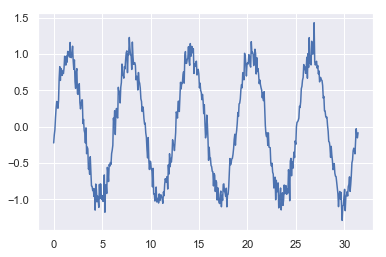

In [3]:
plt.plot(ts, ys)

In [4]:
# 学習設定
batch_size = 32    # ミニバッチサイズ
n_steps = 50       # 入力系列の長さ
input_size = 1     # 入力の次元
hidden_size = 50   #  中間層の次元
output_size = 1    # 出力層の次元

lr = 0.005         # 学習率(SGD)
n_iter = 500       # イテレーション回数

In [5]:
# 訓練データとテストデータに分割
train_ratio = 0.8
data = []
for i in range(len(ys) - n_steps - 1):
    data.append(ys[i: i+n_steps+1])
data = np.array(data, dtype=np.float32)
n_train = int(train_ratio * len(data))
x_train, y_train = np.split(data[:n_train], [-1], axis=1)
x_test, y_test = np.split(data[n_train:], [-1], axis=1)

x_train = np.reshape(x_train, [-1, n_steps, input_size])
x_test = np.reshape(x_test, [-1, n_steps, input_size])

## モデル構築

In [6]:
import chainer.links as L
import chainer.functions as F

class LSTM_Net(chainer.Chain):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_Net, self).__init__()
        # LSTM層とFully connected層を定義
        with self.init_scope():
            self.lstm = L.LSTM(input_size, hidden_size, forget_bias_init=1.0)
            self.l = L.Linear(hidden_size, output_size)
    
    def __call__(self, x):
        """
        順伝播
        x: (batch_size, n_steps, input_size)
        """
        x = F.transpose(x, [1, 0, 2])  # (n_steps, batch_size, input_size)
        # LSTMの初期状態をリセット
        self.lstm.reset_state()
        # 系列順にLSTM層に入力
        for xt in x:
            h = self.lstm(xt)
        return self.l(h)

In [7]:
class RNN(chainer.Chain):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        # RNN層(Wxh + Whh)とFully connected層を定義
        with self.init_scope():
            self.l1 = L.Linear(input_size+hidden_size, hidden_size)
            self.l2 = L.Linear(hidden_size, output_size)
    
    def __call__(self, x):
        """
        順伝播
        x: (batch_size, n_steps, input_size)
        """
        batch_size = len(x)
        # RNNの初期状態
        h = np.zeros([batch_size, self.hidden_size], dtype=np.float32)
        x = F.transpose(x, [1, 0, 2])  # (n_steps, batch_size, input_size)
        # 系列順にRNN層に入力
        for xt in x:
            h = F.tanh(self.l1(F.concat((xt, h))))
        return self.l2(h)        

In [8]:
# モデルをインスタンス化
model = RNN(input_size, hidden_size, output_size)
# model = LSTM_Net(input_size, hidden_size, output_size)
# 最適化手法を設定
# optimizer = chainer.optimizers.SGD(lr=lr)
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

## 学習

In [9]:
# 訓練データのインデックスをランダムに
perm = np.random.permutation(len(x_train))

for i in range(n_iter):
    idx = (i * batch_size) % len(x_train)
    batch_x, batch_y = x_train[perm[idx: idx+batch_size]], y_train[perm[idx: idx+batch_size]]
    
    y = model(batch_x)
    # 損失関数を計算
    loss = F.mean_squared_error(y, batch_y)
    
    # パラメータ更新（勾配のリセット+誤差逆伝播+更新）
    model.zerograds()
    loss.backward()
    optimizer.update()
    
    if i % 50 == 0:
        print("step: {}, loss {:.5f}".format(i, loss.data))

step: 0, loss 0.47047
step: 50, loss 0.01314
step: 100, loss 0.01615
step: 150, loss 0.02083
step: 200, loss 0.00761
step: 250, loss 0.01166
step: 300, loss 0.00877
step: 350, loss 0.01467
step: 400, loss 0.01643
step: 450, loss 0.00966


## テスト

In [10]:
# テストデータに対する予測
prediction = model(x_test)

# 1次元配列に
prediction = prediction.data.reshape(-1)
true_y = y_test.reshape(-1)

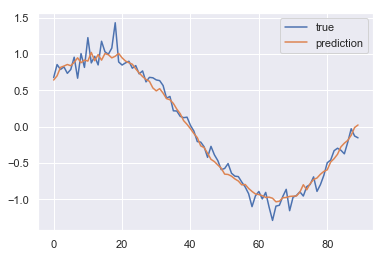

In [11]:
# テストデータに対する予測を可視化
xx = np.arange(len(prediction))
plt.plot(xx, true_y, label='true')
plt.plot(xx, prediction, label='prediction')
plt.legend()

## 再帰的な予測

In [12]:
# テストデータの最初のデータからスタートし、
# モデルの予測を利用し再帰的に予測
curr_x = x_test[0]
predicted = []
# 予測するステップ数
N = 200
for i in range(N):
    # 予測
    predicted.append(model(curr_x[None]).data)
    # 入力を更新
    curr_x = np.insert(curr_x, n_steps, predicted[-1], axis=0)[1:]

# 1次元配列に
predicted = np.array(predicted).reshape(-1)

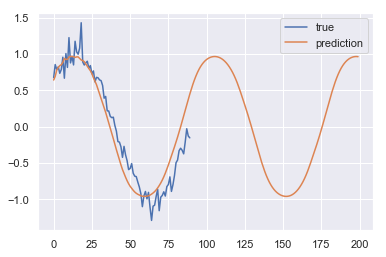

In [13]:
#再帰的な予測を可視化
plt.plot(xx, true_y, label='true')
plt.plot(np.arange(N), predicted, label='prediction')
plt.legend()